In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import functional as TF
from sklearn.metrics import confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [12]:
def show_sample_image(data_dir, classes):
    plt.figure(figsize=(15, 3))
    for idx, class_name in enumerate(classes, 1):
        try:
            class_dir = data_dir / class_name
            first_file = next(class_dir.glob('*.jpg'))
            img = Image.open(first_file)
            plt.subplot(1, len(classes), idx)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
        except (StopIteration, FileNotFoundError):
            print(f"No images found in {class_name}")
        except Exception as e:
            print(f"Error with {class_name}: {e}")
    plt.tight_layout()
    plt.show()

In [3]:
class CNNModel(nn.Module):
    def __init__(self, num_classes, img_size=128):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            # First Convolution Block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            # Second Convolution Block
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * (img_size // 4) * (img_size // 4), 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [4]:
 # For applying transforms on subsets

class TransformedDataset(Dataset):
    
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        image, label = self.subset[index]
        return self.transform(image), label

    def __len__(self):
        return len(self.subset)




def prepare_data_loaders(data_dir, img_size, batch_size, validation_split):
    """
    Fnc. to prepare  with image augmentation
       -train data loaders   &  -validation data loaders 
                      
    Args:
        data_dir (Path): Root dir of the dataset.
        img_size (int): Size (height and width) to resize images.
        batch_size (int): # of samples per batch.
        validation_split (float): % split of data-splitting for validation.
    
    Returns:
        train_loader, val_loader, classes
    """
    train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomResizedCrop((img_size, img_size), scale=(0.9, 1.1)),
        transforms.RandomRotation(15),
        transforms.RandomHorizontalFlip(),
        # here could be added eventualy additional rotation 
        transforms.RandomRotation(72),
        transforms.ToTensor(),
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    full_dataset = ImageFolder(root=str(data_dir))
    
    # Data Splitting:
    dataset_size = len(full_dataset)
    train_size = int((1 - validation_split) * dataset_size)
    val_size = dataset_size - train_size
    train_subset, val_subset = random_split(full_dataset, [train_size, val_size])
    
   

    train_dataset = TransformedDataset(train_subset, train_transforms)
    val_dataset = TransformedDataset(val_subset, val_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return train_loader, val_loader, full_dataset.classes


In [5]:
# Plotting
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 4))
    
    # Accr. plot
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [6]:
# model Evaluaton  and plot of the confusion matrix.
def evaluate_and_plot_predictions(model, val_loader, classes):
    """    
    Args:
        model (nn.Module): The trained CNN model.
        val_loader (DataLoader): DataLoader for the validation set.
        classes (list): List of class names.
        
    Returns:
        dict: Metrics including accuracy and confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    correct = (np.array(all_preds) == np.array(all_labels)).sum()
    total = len(all_labels)
    accuracy = correct / total
    print(f"\nValidation Accuracy: {accuracy:.4f}")

    # normalized confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return {'accuracy': accuracy, 'confusion_matrix': cm}


In [7]:

def main():

    ## # # # # ## # # # # ## # # # # ## # # # # #  ## # # 
    # Hyperparameters and training settings
    # 
    #
    img_size = 128
    batch_size = 32
    #
    epochs = 10  #   <<<<<<<<<<<<  EPOCHS !
    validation_split = 0.2  #  <<<<<<  0.x : x := x% of dataset = Validation
    learning_rate = 0.001  #   <<< Learning Rate
    patience = 5  #   <<<  early stopping patience
    #
    classes = ['basophil', 'erythroblast', 'monocyte', 'myeloblast', 'seg_neutrophil']
    data_dir = Path("/kaggle/input/blood-cell-images-for-cancer-detection")
    model_save_dir = Path("models")
    #
    #
    ## # # # # ## # # # # ## # # # # ## # # # # #  ## # # ## # # # 



    
    show_sample_image(data_dir, classes)
    ## data loaders
    #
    train_loader, val_loader, class_names = prepare_data_loaders(
        data_dir=data_dir,
        img_size=img_size,
        batch_size=batch_size,
        validation_split=validation_split
    )
    
    ##  model init
    #
    model = CNNModel(num_classes=len(class_names), img_size=img_size)
    print("Model architecture:")
    print(model)


    ## # # # # ## # # # # ## # # # # ## # # # # #  ## # # 
    # Define loss, optimizer, and learning rate scheduler
    # 
    #
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=3)
    #
    #
    ## # # # # ## # # # # ## # # # # ## # # # # #  ## # # ## 


    
    # for tracking training history
    best_val_loss = float('inf')
    no_improve = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    ## Training loop
    ##########################
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        ## Validation phase
        ####################
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
        
        # Early stopping 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve = 0
            # saving best model
            model_save_dir.mkdir(exist_ok=True)
            torch.save(model.state_dict(), model_save_dir / 'best_model.pth')
        else:
            no_improve += 1
            if no_improve >= patience:
                print("Early stopping triggered!")
                break

    # pl. training history
    plot_training_history(train_losses, val_losses, train_accs, val_accs)

    # eval. + CM metrics
    metrics = evaluate_and_plot_predictions(model, val_loader, class_names)
    print("Evaluation Metrics:", metrics)

    # saving model
    torch.save(model.state_dict(), model_save_dir / 'CNN_model.pth')
    print(f"Model saved to {model_save_dir / 'CNN_model.pth'}")



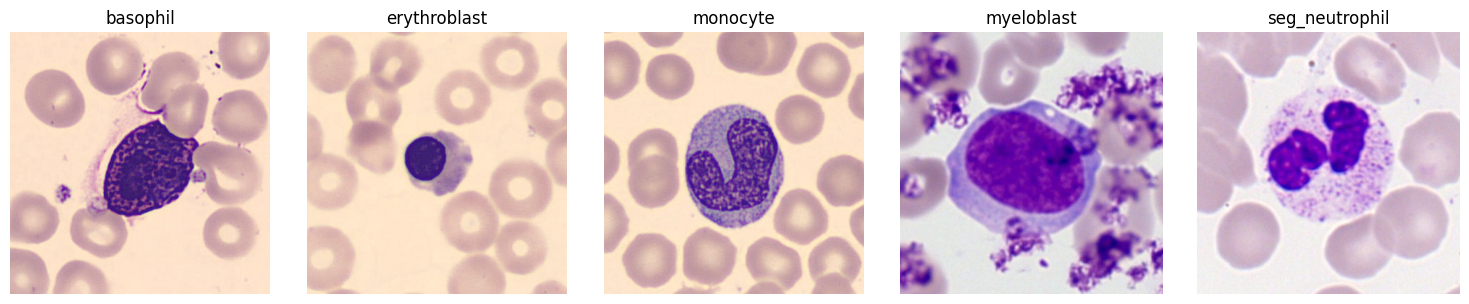

Model architecture:
CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=32, bias=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): Linear(in_features=32, out_features=5, bias=True)

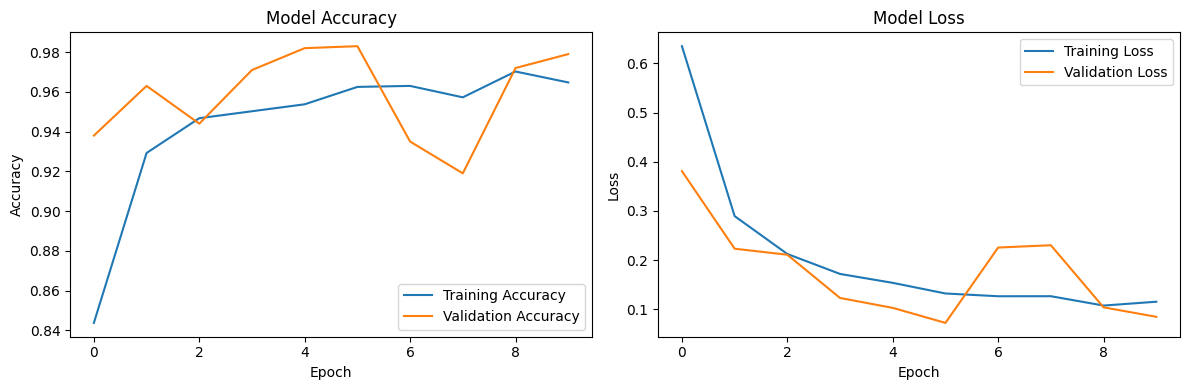


Validation Accuracy: 0.9790


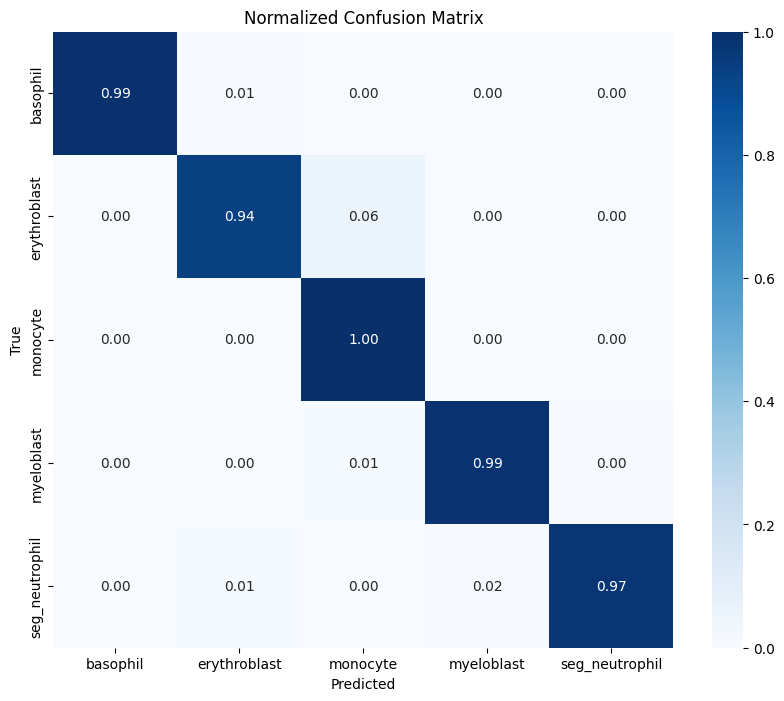

Evaluation Metrics: {'accuracy': 0.979, 'confusion_matrix': array([[193,   1,   0,   0,   0],
       [  0, 192,  12,   0,   0],
       [  0,   0, 189,   0,   0],
       [  0,   0,   2, 211,   1],
       [  0,   2,   0,   3, 194]])}
Model saved to models/CNN_model.pth


In [8]:
main()

In [13]:
device = 'cpu'  
img_size = 128
model_path = Path("models/best_model.pth")
classes = ['basophil', 'lymphocyte', 'neutrophil', 'eosinophil', 'monocyte']



## fn to load the saved model weights into the model.
def load_model(model_path, num_classes, img_size=128, device='cpu'):
    model = CNNModel(num_classes=num_classes, img_size=img_size)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded!")
    return model


## fn to predict the class for a given image.
def predict(model, image_path, transform, classes, device='cpu'):
    # open and transform the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  
    # get prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
    return classes[predicted.item()]



## (torchvision.transforms.Compose): transformation to apply.
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])



In [18]:

###########################################
##  IMAGE TO PREDICT:
image_path = Path("/kaggle/input/blood-cell-images-for-cancer-detection/basophil/BA_112418.jpg")
##
##
model = load_model(model_path, num_classes=len(classes), img_size=img_size, device=device)
predicted_class = predict(model, image_path, transform, classes, device=device)
print(f"\nFor image: '{image_path}'\n\nPredicted class:  >>>>>> {predicted_class} ")


Model loaded!

For image: '/kaggle/input/blood-cell-images-for-cancer-detection/basophil/BA_112418.jpg'

Predicted class:  >>>>>> basophil 


<ipython-input-13-2ec501fa7fff>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
